Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


imagenet_32_resnet50_captum_measures.npz


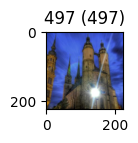

Reference mean:0.05 std:0.01


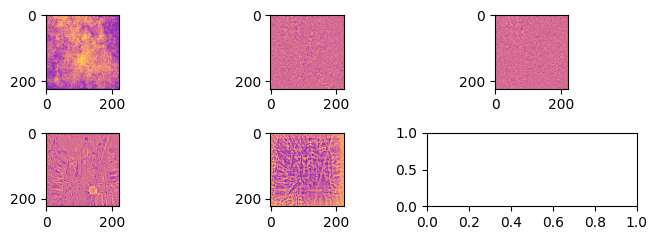

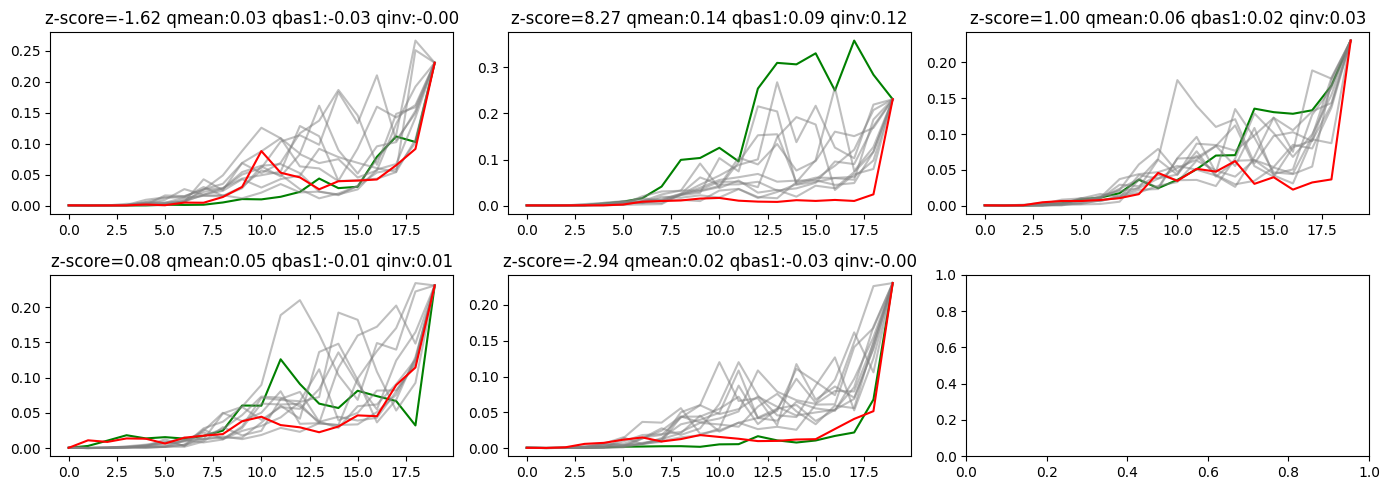

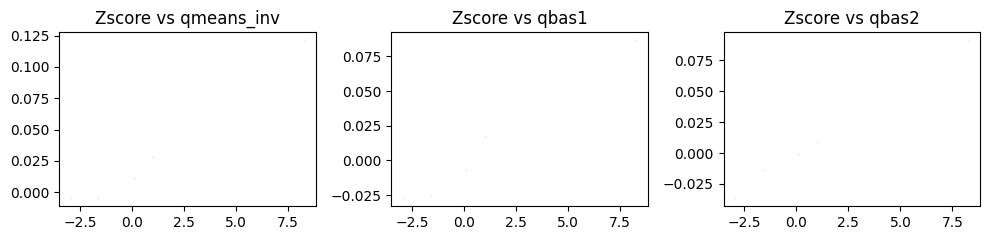

	Correct orderings:
		qmeans_bas1: 1.0000
		qmeans_bas2: 1.0000
		qmeans_bas3: 0.6000
		qmeans_bas4: 1.0000
		qmeans_bas5: 1.0000
		qmeans_bas6: 1.0000
		qmeans_bas7: 1.0000
		qmeans_bas8: 1.0000
		qmeans_bas9: 1.0000
		qmeans_bas10: 1.0000
		--------------------
		qmeans_inv: 1.0000
	Spearman correlation:


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


		qmeans_bas1: 1.0000
		qmeans_bas2: 1.0000
		qmeans_bas3: 0.9000
		qmeans_bas4: 1.0000
		qmeans_bas5: 1.0000
		qmeans_bas6: 1.0000
		qmeans_bas7: 1.0000
		qmeans_bas8: 1.0000
		qmeans_bas9: 1.0000
		qmeans_bas10: 1.0000
		--------------------
		qmeans_inv: 1.0000
	Exceptional detection:
		aucs_bas0 nan | 0.7500 | nan | nan | nan | nan | 1.0000
		aucs_bas1 nan | 0.7500 | nan | nan | nan | nan | 1.0000
		aucs_bas2 nan | 0.5000 | nan | nan | nan | nan | 1.0000
		aucs_bas3 nan | 0.7500 | nan | nan | nan | nan | 1.0000
		aucs_bas4 nan | 0.7500 | nan | nan | nan | nan | 1.0000
		aucs_bas5 nan | 0.7500 | nan | nan | nan | nan | 1.0000
		aucs_bas6 nan | 0.7500 | nan | nan | nan | nan | 1.0000
		aucs_bas7 nan | 0.7500 | nan | nan | nan | nan | 1.0000
		aucs_bas8 nan | 0.7500 | nan | nan | nan | nan | 1.0000
		aucs_bas9 nan | 0.7500 | nan | nan | nan | nan | 1.0000
		--------------------
		aucs_inv nan | 0.7500 | nan | nan | nan | nan | 1.0000
	Spearman correlation for exceptional rankings:
		s

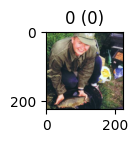

Reference mean:0.18 std:0.04


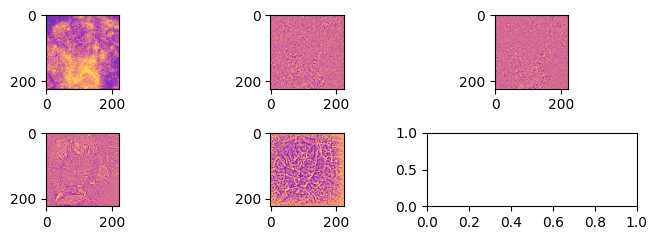

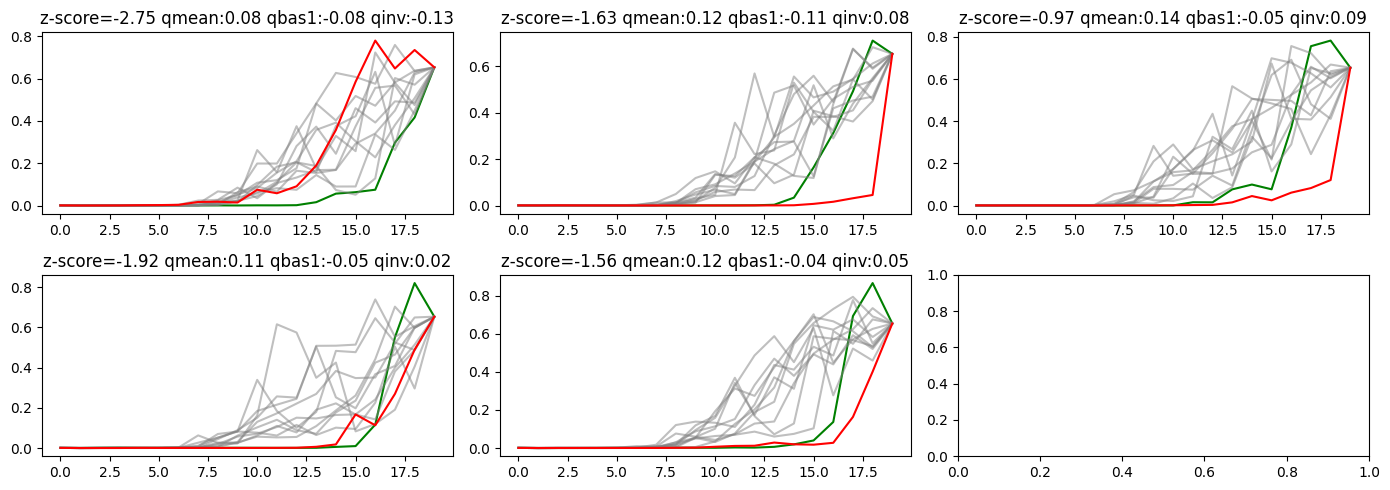

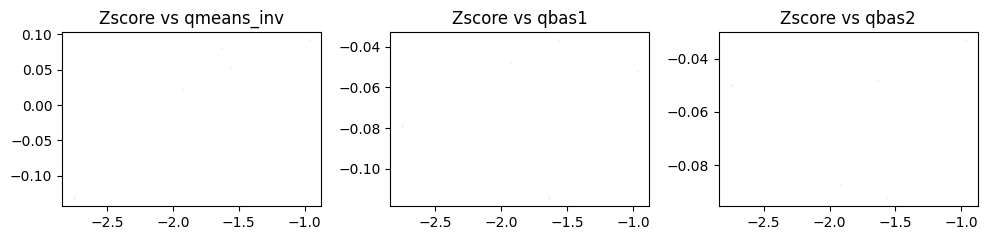

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


	Correct orderings:
		qmeans_bas1: 0.6000
		qmeans_bas2: 0.8000
		qmeans_bas3: 1.0000
		qmeans_bas4: 0.8000
		qmeans_bas5: 0.6000
		qmeans_bas6: 1.0000
		qmeans_bas7: 1.0000
		qmeans_bas8: 1.0000
		qmeans_bas9: 0.6000
		qmeans_bas10: 1.0000
		--------------------
		qmeans_inv: 0.8000
	Spearman correlation:
		qmeans_bas1: 0.3000
		qmeans_bas2: 0.3000
		qmeans_bas3: 0.6000
		qmeans_bas4: 0.2000
		qmeans_bas5: 0.8000
		qmeans_bas6: 0.9000
		qmeans_bas7: 0.9000
		qmeans_bas8: 1.0000
		qmeans_bas9: 0.5000
		qmeans_bas10: 0.9000
		--------------------
		qmeans_inv: 0.9000
	Exceptional detection:
		aucs_bas0 nan | nan | nan | nan | nan | nan | nan
		aucs_bas1 nan | nan | nan | nan | nan | nan | nan
		aucs_bas2 nan | nan | nan | nan | nan | nan | nan
		aucs_bas3 nan | nan | nan | nan | nan | nan | nan
		aucs_bas4 nan | nan | nan | nan | nan | nan | nan
		aucs_bas5 nan | nan | nan | nan | nan | nan | nan
		aucs_bas6 nan | nan | nan | nan | nan | nan | nan
		aucs_bas7 nan | nan | nan | nan | nan

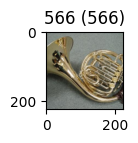

Reference mean:0.45 std:0.02


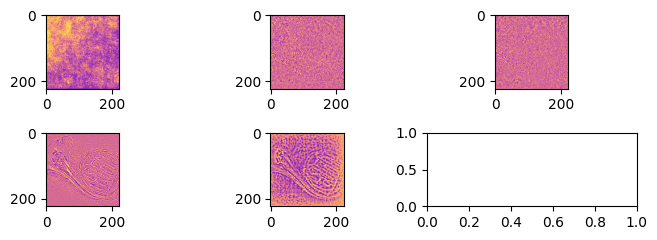

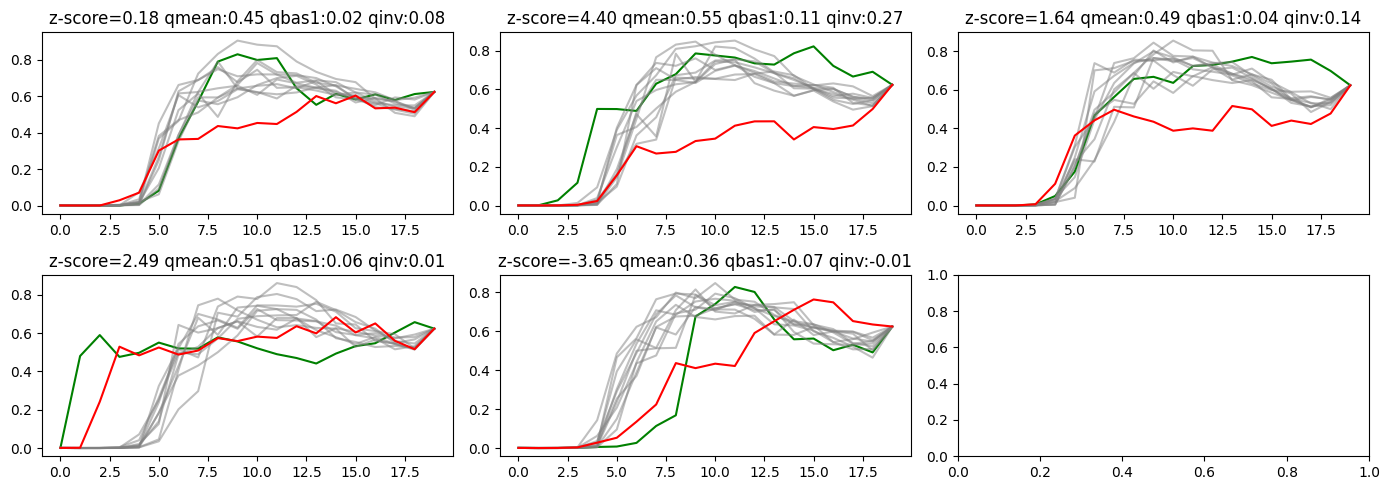

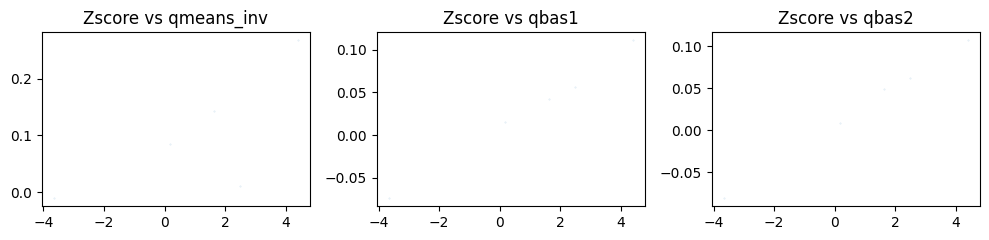

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


	Correct orderings:
		qmeans_bas1: 1.0000
		qmeans_bas2: 1.0000
		qmeans_bas3: 1.0000
		qmeans_bas4: 1.0000
		qmeans_bas5: 1.0000
		qmeans_bas6: 1.0000
		qmeans_bas7: 1.0000
		qmeans_bas8: 1.0000
		qmeans_bas9: 1.0000
		qmeans_bas10: 1.0000
		--------------------
		qmeans_inv: 0.8000
	Spearman correlation:
		qmeans_bas1: 1.0000
		qmeans_bas2: 1.0000
		qmeans_bas3: 1.0000
		qmeans_bas4: 1.0000
		qmeans_bas5: 1.0000
		qmeans_bas6: 1.0000
		qmeans_bas7: 1.0000
		qmeans_bas8: 1.0000
		qmeans_bas9: 1.0000
		qmeans_bas10: 1.0000
		--------------------
		qmeans_inv: 0.7000
	Exceptional detection:
		aucs_bas0 nan | nan | 0.5000 | 0.7500 | nan | nan | 1.0000
		aucs_bas1 nan | nan | 0.5000 | 0.7500 | nan | nan | 1.0000
		aucs_bas2 nan | nan | 0.5000 | 0.7500 | nan | nan | 1.0000
		aucs_bas3 nan | nan | 0.5000 | 0.7500 | nan | nan | 1.0000
		aucs_bas4 nan | nan | 0.5000 | 0.7500 | nan | nan | 1.0000
		aucs_bas5 nan | nan | 0.5000 | 0.7500 | nan | nan | 1.0000
		aucs_bas6 nan | nan | 0.5000 | 0.75

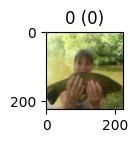

Reference mean:0.13 std:0.02


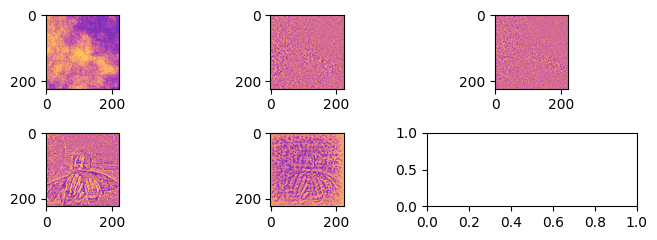

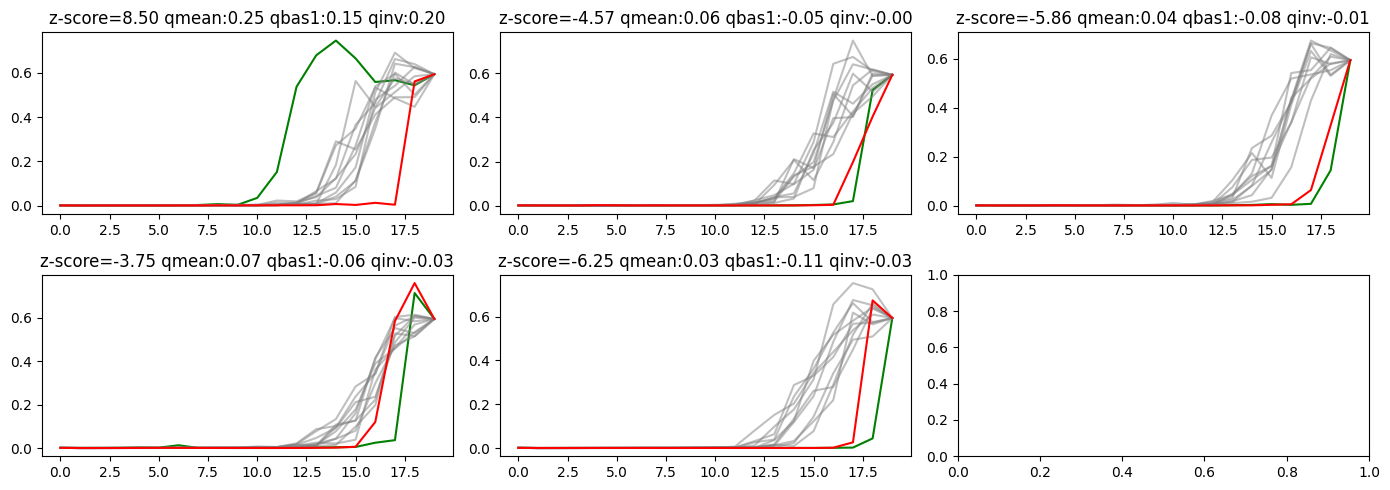

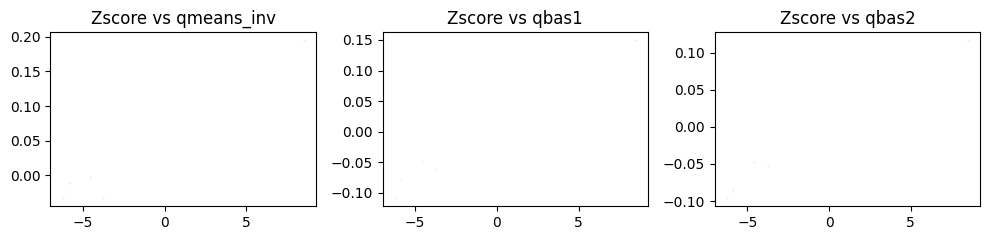

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


	Correct orderings:
		qmeans_bas1: 0.8000
		qmeans_bas2: 1.0000
		qmeans_bas3: 1.0000
		qmeans_bas4: 1.0000
		qmeans_bas5: 1.0000
		qmeans_bas6: 1.0000
		qmeans_bas7: 1.0000
		qmeans_bas8: 1.0000
		qmeans_bas9: 1.0000
		qmeans_bas10: 1.0000
		--------------------
		qmeans_inv: 1.0000
	Spearman correlation:
		qmeans_bas1: 0.9000
		qmeans_bas2: 0.9000
		qmeans_bas3: 0.9000
		qmeans_bas4: 0.9000
		qmeans_bas5: 0.8000
		qmeans_bas6: 1.0000
		qmeans_bas7: 0.9000
		qmeans_bas8: 0.9000
		qmeans_bas9: 1.0000
		qmeans_bas10: 0.9000
		--------------------
		qmeans_inv: 0.4000
	Exceptional detection:
		aucs_bas0 nan | nan | nan | nan | nan | nan | 1.0000
		aucs_bas1 nan | nan | nan | nan | nan | nan | 1.0000
		aucs_bas2 nan | nan | nan | nan | nan | nan | 1.0000
		aucs_bas3 nan | nan | nan | nan | nan | nan | 1.0000
		aucs_bas4 nan | nan | nan | nan | nan | nan | 1.0000
		aucs_bas5 nan | nan | nan | nan | nan | nan | 1.0000
		aucs_bas6 nan | nan | nan | nan | nan | nan | 1.0000
		aucs_bas7 nan | 

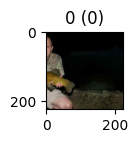

Reference mean:0.22 std:0.02


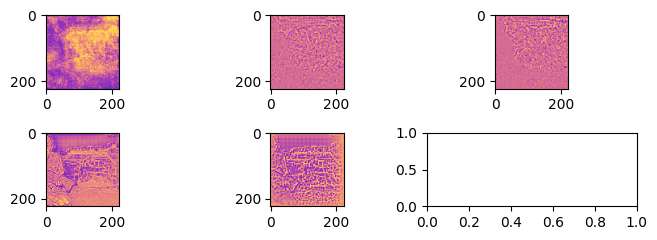

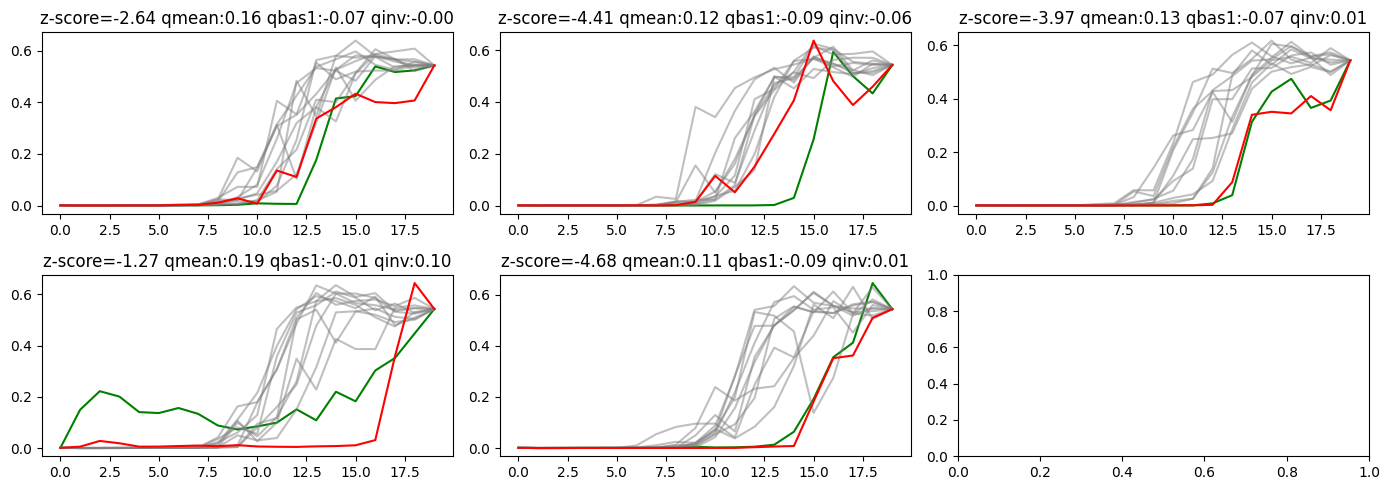

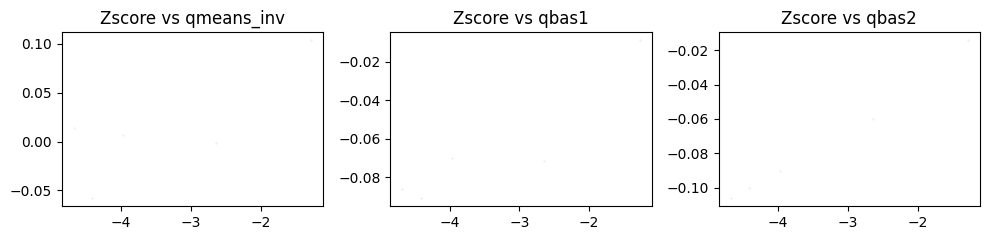

	Correct orderings:
		qmeans_bas1: 1.0000
		qmeans_bas2: 1.0000
		qmeans_bas3: 1.0000
		qmeans_bas4: 1.0000
		qmeans_bas5: 1.0000
		qmeans_bas6: 0.6000
		qmeans_bas7: 1.0000
		qmeans_bas8: 1.0000
		qmeans_bas9: 1.0000
		qmeans_bas10: 1.0000
		--------------------
		qmeans_inv: 0.6000
	Spearman correlation:
		qmeans_bas1: 0.8000
		qmeans_bas2: 1.0000
		qmeans_bas3: 1.0000
		qmeans_bas4: 1.0000
		qmeans_bas5: 1.0000
		qmeans_bas6: 0.9000
		qmeans_bas7: 1.0000
		qmeans_bas8: 0.9000
		qmeans_bas9: 0.9000
		qmeans_bas10: 0.9000
		--------------------
		qmeans_inv: 0.3000
	Exceptional detection:
		aucs_bas0 nan | nan | nan | nan | nan | nan | nan
		aucs_bas1 nan | nan | nan | nan | nan | nan | nan
		aucs_bas2 nan | nan | nan | nan | nan | nan | nan
		aucs_bas3 nan | nan | nan | nan | nan | nan | nan
		aucs_bas4 nan | nan | nan | nan | nan | nan | nan
		aucs_bas5 nan | nan | nan | nan | nan | nan | nan
		aucs_bas6 nan | nan | nan | nan | nan | nan | nan
		aucs_bas7 nan | nan | nan | nan | nan

In [1]:
# %% [markdown]
# # Measure performance
# This notebook loads a file with precomputed measures (*qmeans*, *qbas* & *qinv*) for a set of rankings for a given instance of the dataset and measures the performance of the different alternative measures
# 
# ## 1. Load libraries, model and data

# %%

# Import the necessary libraries
import sys
import os
PROJ_DIR = os.path.realpath(os.path.dirname(os.path.dirname(os.path.abspath(''))))
sys.path.append(os.path.join(PROJ_DIR,'src'))
import xai_faithfulness_experiments_lib_edits as fl
import numpy as np
from typing import Optional
from matplotlib import pyplot as plt

DATASET = 'imagenet'
MODEL_NAME = 'resnet50'
REFERENCE_MODEL_NAME = MODEL_NAME#'resnet50w'
GENERATION = '_captum'

class_names = [str(i) for i in range(1000)]

if DATASET == 'cifar':
    with open(os.path.join(PROJ_DIR, 'assets', 'data', 'cifar-classnames.txt')) as fIn:
        class_names = fIn.readline().strip().split(' ')
    DATA_MEAN = [0.2675, 0.2565, 0.2761]
    DATA_STD = [0.5071, 0.4867, 0.4408]
elif DATASET == 'mnist':
    DATA_MEAN = [0.1307]
    DATA_STD = [0.3081]
elif DATASET == 'imagenet':
    DATA_MEAN = [0.485, 0.456, 0.406]
    DATA_STD = [0.229, 0.224, 0.225]
    #TODO Add imagenette class names

for FILENAME in os.listdir(os.path.join(PROJ_DIR,'results')):
    if FILENAME.startswith(DATASET) and FILENAME.endswith(f'{MODEL_NAME}{GENERATION}_measures.npz'):
        print(FILENAME)

        # Load data
        data = fl.load_generated_data(os.path.join(PROJ_DIR, 'results', FILENAME))
        
        plt.figure(figsize=(1,1))
        plt.imshow(np.moveaxis(data['row'], 0, -1) * DATA_STD + DATA_MEAN, cmap='winter')
        plt.title(f'{class_names[data["label"]]} ({data["label"]})')
        plt.show()
        
        qmeans = data['qmeans']
        #qmeans_basX = [data['qmean_bas']] # We don't look at qmean_bas, it will be recomputed later with the appropriate reference
        qmeans_basX = []
        qmeans_inv = data['qmean_invs']

        # Compute qmeans_bas[2-10]
        def compute_qbas(measure, num_samples, reference:np.ndarray):
            random_indices = np.random.randint(0, measure.shape[0], (measure.shape[0], num_samples))
            random_qmeans = reference[random_indices]
            mean = np.mean(random_qmeans, axis=1)

            # First way to deal with std==0; add some epsilon
            #std = np.std(random_qmeans, axis=1) + 1e-10

            # Second way to deal with std==0; ignore std (divide by 1)
            std = np.std(random_qmeans, axis=1)
            std[std==0] = 1

            # Always ignore std
            std=1
            return (measure - mean) / std
        
        data_reference = data
        qmeans_reference = qmeans
        if GENERATION in ['_genetic', '_captum']:
            # If data is genetic, we'll load the random generated equivalent to compute qbas with
            data_reference = fl.load_generated_data(os.path.join(PROJ_DIR, 'results', FILENAME.replace(GENERATION, '').replace(MODEL_NAME, REFERENCE_MODEL_NAME)))
            qmeans_reference = data_reference['qmeans']

        for i in range(1,11):
            # If data is genetic, compute qbas with random data from other file
            qmeans_basX.append(compute_qbas(qmeans, i, qmeans_reference if GENERATION in ['_genetic', '_captum'] else qmeans))

        # Compute z-score
        qmean_mean = np.mean(qmeans)
        qmean_std = np.std(qmeans)
        
        if GENERATION in ['_genetic', '_captum']:
            qmean_mean = np.mean(qmeans_reference)
            qmean_std = np.std(qmeans_reference)

        z_scores = ((qmeans - qmean_mean) / qmean_std).flatten()
        #DEBUG
        selected_curves = data['output_curves']
        selected_curves_inv = data['output_curves_inv']
        selected_zscores = z_scores
        selected_qmeans = qmeans.flatten()
        selected_qmeans_bas0 = qmeans_basX[0].flatten()
        selected_qmeans_inv = qmeans_inv.flatten()
        selected_rankings = data['rankings']

        if selected_curves.shape[0] > 6:
            best_indices = np.argsort(-qmeans.flatten())
            selected_curves = selected_curves[best_indices[:6]]
            selected_curves_inv = selected_curves_inv[best_indices[:6]]
            selected_zscores = selected_zscores[best_indices[:6]]
            selected_qmeans = selected_qmeans[best_indices[:6]]
            selected_qmeans_bas0 = selected_qmeans_bas0[best_indices[:6]]
            selected_qmeans_inv = selected_qmeans_inv[best_indices[:6]]
            selected_rankings = selected_rankings[best_indices[:6]]
            #print('Selected indices', best_indices[:6])
            #print('\tQ:', qmeans.flatten()[best_indices[:6]])
            #print('\tCurves:', data['output_curves'][best_indices[:6]])

        print(f'Reference mean:{qmean_mean:.2f} std:{qmean_std:.2f}')
        NUM_RANDOM_CURVES = 10
        fig, axs = plt.subplots(2, 3, figsize=(7, 2.5))
        for i in range(selected_curves.shape[0]):
            ranking = selected_rankings[i]
            if ranking.shape[0] == 3:
                ranking = ranking.sum(axis=0, keepdims=True)
            axs[i//3][i%3].imshow(np.moveaxis(-ranking, 0, -1), alpha=0.8, cmap='plasma')
        plt.tight_layout()
        plt.show()
        
        fig, axs = plt.subplots(2, 3, figsize=(14, 5))
        for i in range(selected_curves.shape[0]):
            axs[i//3][i%3].plot(selected_curves[i], color='green')
            for j in range(NUM_RANDOM_CURVES):
                random_index = np.random.randint(0,data_reference['output_curves'].shape[0])
                random_curve = data_reference['output_curves'][random_index]
                #print(f'{i} - Random curve [{random_index} q:{qmeans_reference.flatten()[random_index]:.4f}]:',random_curve)
                axs[i//3][i%3].plot(random_curve, color='gray', alpha=0.5)
            axs[i//3][i%3].plot(selected_curves_inv[i], color='red')
            axs[i//3][i%3].set_title(f'z-score={selected_zscores[i]:.2f} qmean:{selected_qmeans[i]:.2f} qbas1:{selected_qmeans_bas0[i]:.2f} qinv:{selected_qmeans_inv[i]:.2f}')
        plt.tight_layout()
        plt.show()
        #for i in range(selected_curves.shape[0]):
        #    print(f'{np.unique(selected_rankings[i]).size}/{selected_rankings[i].size} unique values')
        #    plt.scatter(selected_rankings[i].flatten(), np.arange(selected_rankings[i].size), s=0.2)
        #    plt.show()
        fig, axs = plt.subplots(1, 3, figsize=(10, 2.5))
        axs[0].scatter(z_scores, qmeans_inv, s=0.1, alpha=0.2)
        axs[0].set_title('Zscore vs qmeans_inv')
        axs[1].scatter(z_scores, qmeans_basX[0], s=0.1, alpha=0.2)
        axs[1].set_title('Zscore vs qbas1')
        axs[2].scatter(z_scores, qmeans_basX[1], s=0.1, alpha=0.2)
        axs[2].set_title('Zscore vs qbas2')
        plt.tight_layout()
        plt.show()

        # Stratify z-index to be able to compare performance on different parts of the spectrum
        indices = np.arange(z_scores.shape[0])
        z_scores_numbered = np.vstack((z_scores, indices))
        level_indices = []
        boundaries = [0.5, 1, 1.5, 2, 2.5, 3, 3.5]
        for i in range(1,len(boundaries)+1):
            bottom_limit = boundaries[i-1]
            top_limit = float('inf')
            if i < len(boundaries):
                top_limit = boundaries[i]
            level_indices.append((z_scores_numbered[:,np.logical_and(bottom_limit<=z_scores, z_scores<top_limit)][1,:].astype(int),(bottom_limit, top_limit)))
        
        # %% [markdown]
        # ## 2. Measure performance
        # ### 2.1 Order preservation
        #  1. The issue with using qmean directly is that it doesn't have a fixed scale and you don't get an idea of how good your explanation is compared to other explanations
        #  2. To address this, ideally you would determine the distribution of all qmeans and then compute the z-score. That's very costly, so you either:
        #     1. Estimate the qmeans distribution with X samples $\rightarrow$ qbasX
        #     2. Calculate an alternative to the z-index directly $\rightarrow$ qinv
        #  3. The problem with both alternatives is that you adulterate the value of your original qmean measurement, so you may end up in a situation where $qmean_i<qmean_j$ but $qinv_i<qinv_j$, which is undesirable
        #  4. Hence, we measure how many times that happens for each measure.
        # 
        #  (This may be measuring the same as Pearson correlation, which is computed below)

        # %%
        def measure_correct_orderings(truths, estimators):
            '''
            Creates len(truth) x,y pairs and computes the fraction of them for which (truths[x]<truths[y] and estimators[x]<estimators[y]) or (truths[x]>truths[y] and estimators[x]>estimators[y])
            Inputs:
                - Truths & estimators contain num_elems floats
            Output:
                - Float representing the fraction of correctly ordered pairings
            '''
            xs = np.random.permutation(truths.size)
            ys = np.random.permutation(truths.size)
            truthX_lt_Y = truths[xs] < truths[ys]
            estimatorX_lt_Y = estimators[xs] < estimators[ys]
            hits = truthX_lt_Y==estimatorX_lt_Y
            return hits.sum()/truths.size

        print('\tCorrect orderings:')
        correct_pairings_basX = []
        for i in range(len(qmeans_basX)):
            correct_pairings_basX.append(measure_correct_orderings(qmeans, qmeans_basX[i]))
            print(f'\t\tqmeans_bas{i+1}: {correct_pairings_basX[i]:.4f}')
        correct_pairings_inv = measure_correct_orderings(qmeans, qmeans_inv)
        print('\t\t'+'-'*20)
        print(f'\t\tqmeans_inv: {correct_pairings_inv:.4f}')

        # %% [markdown]
        # ### 2.2. Spearman correlation
        # Same thing, is the order of qmeans preserved in qbasX/qinv?

        # %%
        print('\tSpearman correlation:')
        from scipy.stats import spearmanr
        spearman_basX = []
        for i in range(len(qmeans_basX)):
            spearman_basX.append(spearmanr(qmeans, qmeans_basX[i])[0])
            print(f'\t\tqmeans_bas{i+1}: {spearman_basX[i]:.4f}')
        spearman_inv = spearmanr(qmeans, qmeans_inv)[0]
        print('\t\t'+'-'*20)
        print(f'\t\tqmeans_inv: {spearman_inv:.4f}')

        # %% [markdown]
        # ### 2.3. Ability to detect exceptionally good rankings
        # As stated above, there are some ordering errors in the estimators. Are they in the relevant part of the distribution? i.e. Do they affect the ability to identify exceptionally good rankings?

        # %%
        from sklearn import metrics

        def measure_detection(target_indices, estimator):
            if (len(target_indices)==0) or (len(target_indices) == estimator.shape[0]):
                return float('nan')
            target = np.zeros_like(estimator, dtype=int)
            target[target_indices] = 1
            return metrics.roc_auc_score(target, estimator)

        aucs_inv = []
        aucs_basX = [[] for i in qmeans_basX]

        for indices, (bottom_limit, upper_limit) in level_indices:
            aucs_inv.append(measure_detection(indices, qmeans_inv))
            for i in range(len(qmeans_basX)):
                aucs_basX[i].append(measure_detection(indices, qmeans_basX[i]))

        print('\tExceptional detection:')
        for i in range(len(qmeans_basX)):
            print(f'\t\taucs_bas{i} ' + ' | '.join(map(lambda x: f'{x:.4f}',aucs_basX[i])))
        print('\t\t'+'-'*20)
        print('\t\taucs_inv ' + ' | '.join(map(lambda x: f'{x:.4f}',aucs_inv)))


        # %% [markdown]
        # ### 2.4 Ability to rank exceptionally good rankings
        # How well is the order preserved for exceptionally good rankings?

        # %%
        spearman_exceptional_inv = []
        spearman_exceptional_basX = [[] for i in qmeans_basX]

        for indices, (bottom_limit, upper_limit) in level_indices:
            spearman_exceptional_inv.append(spearmanr(qmeans[indices], qmeans_inv[indices])[0])
            for i in range(len(qmeans_basX)):
                spearman_exceptional_basX[i].append(spearmanr(qmeans[indices], qmeans_basX[i][indices])[0])

        print('\tSpearman correlation for exceptional rankings:')
        for i in range(len(qmeans_basX)):
            print(f'\t\tspearman_exceptional_bas{i} ' + ' | '.join(map(lambda x: f'{x:.4f}', spearman_exceptional_basX[i])))
        print('\t\t'+'-'*20)
        print('\t\tspearman_exceptional_inv ' + ' | '.join(map(lambda x: f'{x:.4f}', spearman_exceptional_inv)))